In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from scipy.optimize import minimize

from tf_keras_vis.layercam import Layercam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

In [2]:
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device="cuda")

predictor = SamPredictor(sam)

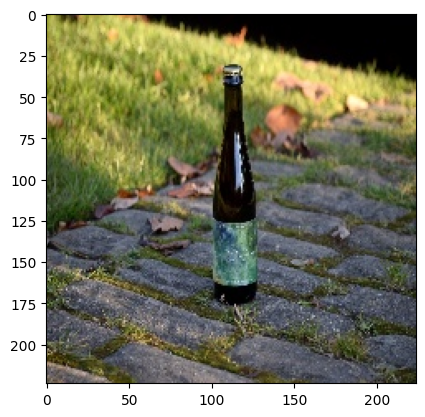

In [51]:
image_path = r'Imagenes_test\glass 852.jpg'.replace('\\', '/')
img_array = cv2.imread(image_path)
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
predictor.set_image(img_array)
plt.imshow(img_array)
plt.show()

In [4]:
# Predict the masks
from tensorflow import keras
DIR_MODEL = 'models/xception_fine_no_freeze_flatten.h5'
model = keras.models.load_model(DIR_MODEL)

In [5]:
gradcam = Layercam(
    model,
    model_modifier=ReplaceToLinear(),
)

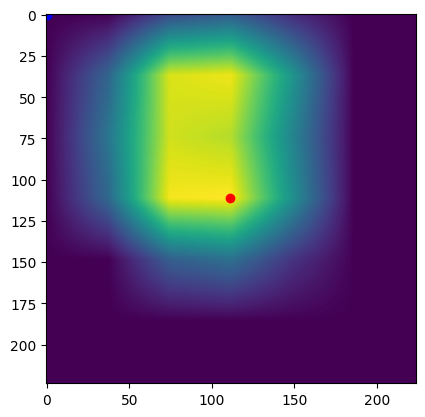

In [48]:
cam = gradcam(CategoricalScore(9), img_array / 255.0, penultimate_layer=-1)[0]
# Max x y in cam
max = np.argmax(cam)
min = np.argmin(cam)
max_x = max % cam.shape[1]
max_y = max // cam.shape[1]
min_x = min % cam.shape[1]
min_y = min // cam.shape[1]
max = np.array([max_x, max_y])
min = np.array([min_x, min_y])
plt.imshow(cam)
plt.scatter(max_x, max_y, c='r')
plt.scatter(min_x, min_y, c='b')
plt.show()

In [49]:
def func(coords):
    points1 = coords[:2]
    points2 = coords[2:]
    print(points1, points2)
    points_g = np.array([points1])
    labels_g = np.array([1])
    points_b = np.array([points2])
    points_b = np.concatenate((points_g, points_b), axis=0)
    labels_b = np.array([1, 0])
    masks, _, low = predictor.predict(point_coords=points_g, point_labels=labels_g, multimask_output=False)
    masks, _, low = predictor.predict(point_coords=points_b, point_labels=labels_b, multimask_output=False, mask_input = low)
    img_masked = cv2.bitwise_and(img_array, img_array, mask=masks[0].astype(np.uint8))
    img_masked = np.expand_dims(img_masked, axis=0)
    img_masked = img_masked / 255.0
    pred = model.predict(img_masked, verbose=0)
    error = 1 - pred[0][0]
    print(error)
    return error

res = minimize(func, [max[0], max[1], min[0], min[1]], method='Powell', bounds=[(0, 224), (0, 224), (0, 224), (0, 224)], options={'disp': True})
print(res.x)

[111. 111.] [0. 0.]
0.9267140924930573
[ 85.56038652 111.        ] [0. 0.]
0.8616652488708496
[138.43961348 111.        ] [0. 0.]
0.9850857416167855
[ 52.87922696 111.        ] [0. 0.]
0.8069094568490982
[ 32.68115956 111.        ] [0. 0.]
0.8679776042699814
[ 59.79245466 111.        ] [0. 0.]
0.8747975677251816
[ 52.87919276 111.        ] [0. 0.]
0.8069094568490982
[ 52.87915857 111.        ] [0. 0.]
0.8069094568490982
[ 45.16420945 111.        ] [0. 0.]
0.8843951895833015
[ 49.93231023 111.        ] [0. 0.]
0.8877527564764023
[ 51.75356266 111.        ] [0. 0.]
0.857454776763916
[ 52.44921919 111.        ] [0. 0.]
0.8220486491918564
[ 52.71493634 111.        ] [0. 0.]
0.8141901791095734
[ 52.81643126 111.        ] [0. 0.]
0.8037562668323517
[ 52.77766365 111.        ] [0. 0.]
0.8148116320371628
[ 52.84039096 111.        ] [0. 0.]
0.8037562668323517
[ 52.82841111 111.        ] [0. 0.]
0.8037562668323517
[ 52.82383521 111.        ] [0. 0.]
0.8037562668323517
[ 52.82100715 111.        ]

[[97.04480015 71.28529164]
 [69.65717226 64.12758224]]


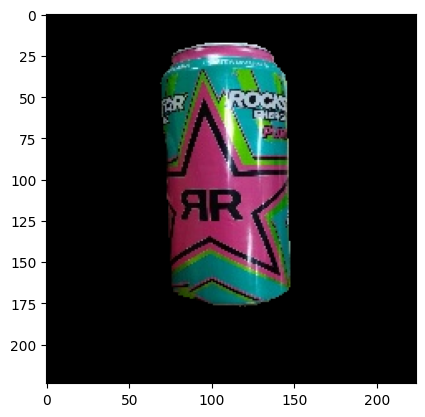

True

In [50]:
points1 = np.array([res.x[:2]])
points2 = np.array([res.x[2:]])
points2 = np.concatenate((points1, points2), axis=0)
labels_b = np.array([1, 0])
print(points2)
mask1, _, low = predictor.predict(point_coords=points1, point_labels=np.array([1]), multimask_output=False)
mask2, _, _ = predictor.predict(point_coords=points2, point_labels=labels_b, multimask_output=False, mask_input = low)

img_masked = cv2.bitwise_and(img_array, img_array, mask=mask2[0].astype(np.uint8))
plt.imshow(img_masked)
plt.show()
cv2.imwrite('pred.jpg', cv2.cvtColor(img_masked, cv2.COLOR_RGB2BGR))